# Método Cadena Markov-Monte Carlo (MCMC)¶

In [190]:
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using Random
using Base.Threads: @threads,@spawn
using Plots
using PyCall
using DataFrames

## Funciones para construir el sistema $Ax = b$. Se debe usar un número entero par mayor que cero.



In [191]:

function matriz_vector_sist( n )
    M = Tridiagonal(-1*ones(n-1), 3*ones(n), -1*ones(n-1))
    M = M + zeros(n,n)
    for i = 1:n
        if i != n/2 && i != n/2 + 1
            M[i,n+1-i] = 0.5
        end
    end
    
    b = zeros(n)
    b[1] = 5/2
    b[n] = 5/2
    for i = 2:n-1
        if i == n/2 || i == n/2+1
            b[i] = 1
        else
            b[i] = 3/2
        end
    end
    
    return A,b
end

matriz_vector_sist (generic function with 1 method)

In [192]:
function matriz_vector_sistema(n)
    e = ones(n)
    n2 =Int(n/2)
    diags = [-1,0,1]
    A = Matrix(spdiagm(-1 => -ones(n-1)
        ,0 => 3*ones(n),1 => -ones(n-1)))
    c = spdiagm(0 => ones(n)/2)
    ab = [x for x=1:n]
    ba = [(n+1)-x for x=1:n]
    c = Matrix(permute(c, ba, ab))

    A = A + c
    A[n2+1,n2] = -1
    A[n2,n2+1] = -1
    
    b = zeros(n,1)
    b[1] = 2.5
    b[n] = 2.5
    b[2:n-1] .= [1.5]
    b[n2:n2+1] .= [1]
    return A,b
end

matriz_vector_sistema (generic function with 1 method)

In [193]:
n = 30
A, b = matriz_vector_sistema(n)
nA = norm(A);
typeof(A)

Array{Float64,2}

In [194]:
typeof(b)

Array{Float64,2}

## 1. Implementac MCMC con mejores práticas de Julia
A continuación se muestran diversas versiones del Método de Monte Carlo Cadenas de MArkov (MCMC) con la finalidad de evaluar la eficiencia y escalabilidad.

### a) MCMC con matriz de probabilidad in situ.
Esta primera versión del método crea las matrices auxiliares y posteriormente son utilizadas como variables globales. Adicionalmente, para elegir los elementos de T, f y P, Pi necesarios para construir las cadenas de Markov se hace una suma acumulada de probabilidades cada vez que se calcula un elemento de cada cadena.

In [195]:
M = diagm(0 => diag(A))
N = M-A
T = inv(M) * N
f = inv(M) * b
nT, mT = size(T);

In [196]:
S = fill(0, nT)
P = fill(0., nT, mT) 
[S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
[P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
Pi = [1/nT for i in 1:nT];

In [197]:
ϵ = 0.001
δ = 0.1 
Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1

130.0

In [198]:
function mcmcalg1(ϵ, Nc) 
    Xs = fill(0., mT)
    for i in 1:mT
        W_0 = 1
        for s in 1:Nc
            W = W_0; k = 0; point = i; X = W_0 * f[i]
            while abs(W) >= ϵ
                nextpoint  = 1
                u = rand()
                while u >= sum(P[point, 1:nextpoint])  #probabilidad acumulada in-situ
                    nextpoint = nextpoint + 1
                end
                k = k + 1
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint]) # T,P variables globales
                    X = X + W_new * f[nextpoint] # f variables globales
                point = nextpoint
                W = W_new
            end
        Xs[i] += X
        end
    end
    Xs = Xs/Nc
end

mcmcalg1 (generic function with 1 method)

In [199]:
TEalg1 = @benchmark mcmcalg1(ϵ, Nc) 

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  255.816 ms … 274.714 ms  ┊ GC (min … max): 15.27% … 16.69%
 Time  (median):     262.161 ms               ┊ GC (median):    16.61%
 Time  (mean ± σ):   262.488 ms ±   4.807 ms  ┊ GC (mean ± σ):  16.41% ±  0.69%

  ▁  ▁ ▁▁ ▁  █ ▁ ▁  ▁   █▁▁   ▁  ▁   ▁     ▁ ▁                ▁  
  █▁▁█▁██▁█▁▁█▁█▁█▁▁█▁▁▁███▁▁▁█▁▁█▁▁▁█▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  256 ms           Histogram: frequency by time          275 ms <

 Memory estimate: 378.42 MiB, allocs estimate: 7541839.

### b) MCCM con matriz de probabilidad acumulada fuera del algoritmo, variable global
Se calcula la suma de probabilidad acumulada fuera del algoritmo mcmc. Continúa el uso de las matrices T, Pa, P y el vector f como variables globales.

In [200]:
M = diagm(0 => diag(A))
N = M-A
T = inv(M) * N
f = inv(M) * b
nT, mT = size(T);

In [201]:
S = fill(0, nT)
Pa = P = fill(0., nT, mT)
[S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
[P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
Pi = [1/nT for i in 1:nT];

In [202]:
function mcmcalg2(ϵ, Nc)
    Xs = fill(0., mT)
    for i in 1:mT
        W_0 = 1.0
        for s in 1:Nc
            W = W_0;  point = i; X = W_0 * f[i]
            while abs(W) >= ϵ
                nextpoint = 1
                u = rand()
                while u >= Pa[point][nextpoint]
                    nextpoint += 1
                end
                    W_new = W *(T[point, nextpoint]/P[point,nextpoint])
                    X += W_new * f[nextpoint]
                point = nextpoint
                W = W_new
            end
        Xs[i] += X
        end
    end
    Xs = Xs/Nc
end

mcmcalg2 (generic function with 1 method)

In [203]:
TEalg2 = @benchmark mcmcalg2(ϵ, Nc)

BenchmarkTools.Trial: 43 samples with 1 evaluation.
 Range (min … max):  108.464 ms … 131.612 ms  ┊ GC (min … max): 2.16% … 5.22%
 Time  (median):     117.587 ms               ┊ GC (median):    2.60%
 Time  (mean ± σ):   117.546 ms ±   5.639 ms  ┊ GC (mean ± σ):  3.35% ± 1.20%

       ▃  █▃     █  ▃  ▃   ▃▃█ ▃           ▃ ▃                   
  ▇▁▇▇▁█▇▁██▁▇▁▁▁█▁▇█▁▁█▁▇▇███▁█▇▇▁▁▁▇▇▁▁▁▇█▁█▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▇▇ ▁
  108 ms           Histogram: frequency by time          132 ms <

 Memory estimate: 64.68 MiB, allocs estimate: 4238501.

### c) MCCM con variables locales.
A continuación se envuelve en la función el cálculo de las matrices M,N,T y el vector f por lo que es necesrio enviar como argumentos de la función a la matriz A y el vector b.

In [204]:
function mcmcalg3(ϵ, δ, A, b) 
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T)
    S = fill(0, nT)
    Pa = P = fill(0., nT, mT) 
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
    Pi = [1/nT for i in 1:nT];
    Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1
  
    Xs = fill(0., mT)

    for i in 1:mT
        W_0 = 1
        for s in 1:Nc
            W = W_0; k = 0; point = i; X = W_0 * f[i]
            while abs(W) >= ϵ
                nextpoint  = 1
                u = rand()
                while u >= Pa[point][nextpoint]
                    nextpoint = nextpoint + 1
                end
                k = k + 1
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint])
                    X = X + W_new * f[nextpoint]
                point = nextpoint
                W = W_new
            end
        Xs[i] += X
        end
    end
    Xs = Xs/Nc
end

mcmcalg3 (generic function with 1 method)

In [205]:
TEalg3 = @benchmark mcmcalg3(ϵ, δ, A, b)

BenchmarkTools.Trial: 1352 samples with 1 evaluation.
 Range (min … max):  2.793 ms … 21.172 ms  ┊ GC (min … max): 0.00% … 27.01%
 Time  (median):     3.024 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.691 ms ±  2.483 ms  ┊ GC (mean ± σ):  0.16% ±  1.34%

  █▇▅▃▂                                                 ▂     
  ██████▇▇▇▇▁▄▁▄▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▆██▄▄ █
  2.79 ms      Histogram: log(frequency) by time     14.3 ms <

 Memory estimate: 70.00 KiB, allocs estimate: 100.

### d) MCCM con Matriz de probabilidad acumulada pre-build con envío de parámetros y type-anotations
Se usan variables locales, se envÍan como argumentos la matriz A y el vector b. Se calcula la matriz de probabilidad acumulada fuera del algoritmo mcmc y se usan anotaciones de tipos.

In [206]:
function mcmcalg4(ϵ::Float64, δ::Float64, A::Array{Float64,2}, b::Array{Float64,2})
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T)
    S = fill(0, nT)
    Pa = P = fill(0., nT, mT) 
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
    Pi = [1/nT for i in 1:nT]
    Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1
    
    Xs = fill(0., mT)
    for i in 1:mT
        W_0 = 1.0
        for s in 1:Nc
            W = W_0; point = i; X = W_0 * f[i]::Float64
            while abs(W) >= ϵ
                nextpoint  = 1::Int64
                u = rand()::Float64
                while u >= Pa[point][nextpoint]::Float64
                    nextpoint = nextpoint + 1::Int64
                end
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint])::Float64
                    X = X + W_new * f[nextpoint]::Float64
                point = nextpoint::Int64
                W = W_new::Float64
            end
        Xs[i] += X::Float64
        end
    end
    Xs = Xs/Nc::Float64
end

mcmcalg4 (generic function with 2 methods)

In [207]:
TEalg4 = @benchmark mcmcalg4(ϵ, δ, A, b)

BenchmarkTools.Trial: 1553 samples with 1 evaluation.
 Range (min … max):  2.724 ms … 14.361 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.955 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.222 ms ±  1.475 ms  ┊ GC (mean ± σ):  0.11% ± 1.76%

  █▃                                                          
  ██▇▄▃▂▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂ ▂
  2.72 ms        Histogram: frequency by time        13.6 ms <

 Memory estimate: 70.00 KiB, allocs estimate: 100.

## 2. Cálculo de tiempos de ejecución

2.55816097e8 || A). Probabilidad in situ
1.08464174e8 || B). Probabilidad acumulada fuera del algoritmo, variable global
2.793492e6 || C). Variables locales
2.72443e6 || D). Probabilidad acumulada pre-build con envío de parámetros y type-anotations


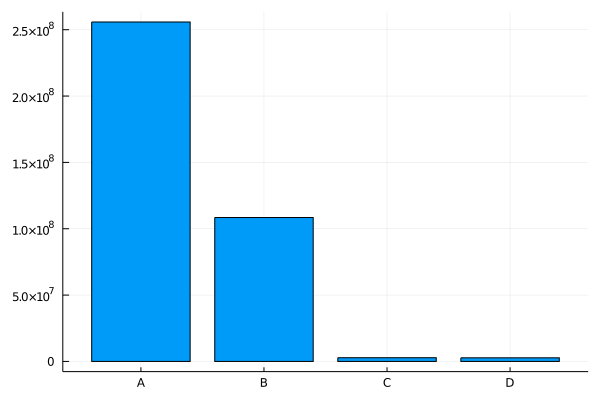

In [208]:
println(minimum(TEalg1).time," || A). Probabilidad in situ")
println(minimum(TEalg2).time," || B). Probabilidad acumulada fuera del algoritmo, variable global")
println(minimum(TEalg3).time," || C). Variables locales")
println(minimum(TEalg4).time," || D). Probabilidad acumulada pre-build con envío de parámetros y type-anotations")
using  DataFrames
arrMCMC= ["A","B","C","D"]
arrTime= [minimum(TEalg1).time,minimum(TEalg2).time,minimum(TEalg3).time,minimum(TEalg4).time]
bar(arrMCMC, arrTime,  label="")

## 3. Aumento de tamaño del Sitema de Ecuaciones Lineales Algebraico
Se varia el tamaño del Sistema de Ecuaiones Lineales Algebraico (SELA) y se cálculan los tiempos
a 10x10, 30x30, 50x50

### I. Cálculo de tiempos con Probabilidad in situ

In [209]:
arrTEalg1 = []
mxn = [6, 10, 30, 50, 100]

for n = mxn
    print(n)
    A,b = matriz_vector_sistema(n)
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T);
    S = fill(0, nT)
    P = fill(0., nT, mT) 
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pi = [1/nT for i in 1:nT];
    ϵ = 0.001
    δ = 0.1 
    Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1
    TE1 = @benchmark mcmcalg1(ϵ, Nc) seconds=1
    push!(arrTEalg1, TE1)
end

6103050100

### II. Cálculo de tiempos con Probabilidad acumulada fuera del algoritmo, variable global

In [210]:
arrTEalg2 = []
mxn = [6, 10, 30, 50, 100]

for n = mxn
    print(n)
    A,b = matriz_vector_sistema(n)
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T);
    S = fill(0, nT)
    Pa = P = fill(0., nT, mT)
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
    Pi = [1/nT for i in 1:nT];
    TE2 = @benchmark mcmcalg2(ϵ, Nc) seconds=1
    push!(arrTEalg2, TE2)
end

6103050100

### III. Cálculo de timepos con Variables locales

In [211]:
arrTEalg3 = []
mxn = [6, 10, 30, 50, 100]

for n = mxn
    print(n)
    A,b = matriz_vector_sistema(n)
    ϵ = 0.001
    δ = 0.1 
    TE3 = @benchmark mcmcalg3(ϵ, δ, A, b) seconds=1
    push!(arrTEalg3, TE3)
end

6103050100

### IV. Cálculo de timepos con Type-anotations

In [212]:
arrTEalg4 = []
mxn = [6, 10, 30, 50, 100]

for n = mxn
    print(n)
    A,b = matriz_vector_sistema(n)
    ϵ = 0.001
    δ = 0.1 
    TE4 = @benchmark mcmcalg4(ϵ, δ, A, b) seconds=1
    push!(arrTEalg4, TE4)
end

6103050100

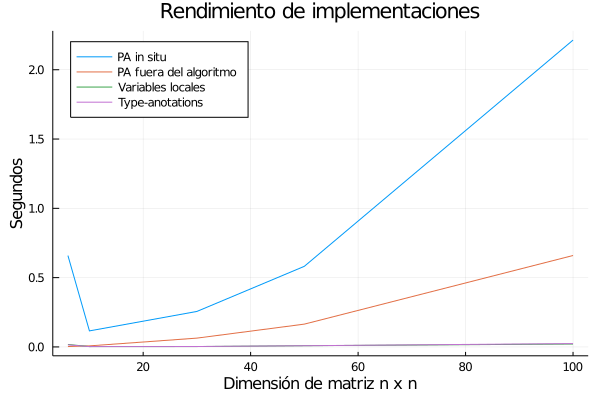

In [213]:
plot(title="Rendimiento de implementaciones", legend=:topleft, xaxis="Dimensión de matriz n x n", yaxis="Segundos")
plot!(mxn, [minimum(arrTEalg1[i]).time/10^9  for i=1:size(mxn)[1]], label="PA in situ")
plot!(mxn, [minimum(arrTEalg2[i]).time/10^9  for i=1:size(mxn)[1]], label="PA fuera del algoritmo")
plot!(mxn, [minimum(arrTEalg3[i]).time/10^9  for i=1:size(mxn)[1]], label="Variables locales")
plot!(mxn, [minimum(arrTEalg4[i]).time/10^9  for i=1:size(mxn)[1]], label="Type-anotations")


## 4. Implementación de SELA dispersos
Implementamos el uso de SparseArrays.jl para  optimizar la memoria en el Sistema de Ecuaiones Lineales Algebraico

In [214]:
function mcmcalg5(ϵ::Float64, δ::Float64, A::Array{Float64,2}, b::Array{Float64,2})
    
    A = dropzeros(sparse(A))
    b = dropzeros(sparse(b))
    
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T)
    S = fill(0, nT)
    Pa = P = fill(0., nT, mT) 
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
    Pi = [1/nT for i in 1:nT]
    Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1
    
    Xs = fill(0., mT)
    for i in 1:mT
        W_0 = 1.0
        Threads.@threads for s in 1:Nc
            W = W_0; point = i; X = W_0 * f[i]::Float64
            while abs(W) >= ϵ
                nextpoint  = 1::Int64
                u = rand()::Float64
                while u >= Pa[point][nextpoint]::Float64
                    nextpoint = nextpoint + 1::Int64
                end
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint])::Float64
                    X = X + W_new * f[nextpoint]::Float64
                point = nextpoint::Int64
                W = W_new::Float64
            end
        Xs[i] += X::Float64
        end
    end
    Xs = Xs/Nc::Float64
end

mcmcalg5 (generic function with 1 method)

In [215]:
TEalg5 = @benchmark mcmcalg5(ϵ, δ, A, b)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  520.910 ms …    1.452 s  ┊ GC (min … max): 1.96% … 1.42%
 Time  (median):     538.445 ms               ┊ GC (median):    1.97%
 Time  (mean ± σ):   654.831 ms ± 322.703 ms  ┊ GC (mean ± σ):  1.85% ± 0.52%

  █▁                                                             
  ██▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▁
  521 ms           Histogram: frequency by time          1.45 s <

 Memory estimate: 166.87 MiB, allocs estimate: 10882407.

## 5. Implementación de estrategía de Cómputo de Alto Rendimiento
Se prueba la implementación de Threads simplificados para disminuir el tiempo de ejecución de MCMC

#### Número de hilos para la ejecucución

In [292]:
Threads.nthreads()=4
Threads.nthreads()

4

In [216]:
function mcmcalg6(ϵ::Float64, δ::Float64, A::Array{Float64,2}, b::Array{Float64,2})
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T)
    S = fill(0, nT)
    Pa = P = fill(0., nT, mT) 
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
    Pi = [1/nT for i in 1:nT]
    Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1
    
    Xs = fill(0., mT)
    for i in 1:mT
        W_0 = 1.0
        Threads.@threads for s in 1:Nc
            W = W_0; point = i; X = W_0 * f[i]::Float64
            while abs(W) >= ϵ
                nextpoint  = 1::Int64
                u = rand()::Float64
                while u >= Pa[point][nextpoint]::Float64
                    nextpoint = nextpoint + 1::Int64
                end
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint])::Float64
                    X = X + W_new * f[nextpoint]::Float64
                point = nextpoint::Int64
                W = W_new::Float64
            end
        Xs[i] += X::Float64
        end
    end
    Xs = Xs/Nc::Float64
end

mcmcalg6 (generic function with 1 method)

In [217]:
TEalg6 = @benchmark mcmcalg6(ϵ, δ, A, b)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  519.714 ms …    1.434 s  ┊ GC (min … max): 2.67% … 1.61%
 Time  (median):     538.037 ms               ┊ GC (median):    2.07%
 Time  (mean ± σ):   650.566 ms ± 316.894 ms  ┊ GC (mean ± σ):  1.94% ± 0.43%

  █▁                                                             
  ██▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▁
  520 ms           Histogram: frequency by time          1.43 s <

 Memory estimate: 166.83 MiB, allocs estimate: 10886072.

In [218]:
arrTEalg5 = []
arrTEalg6 = []
mxn = [6, 10, 30, 50, 100]

for n = mxn
    print(n)
    A,b = matriz_vector_sistema(n)
    ϵ = 0.001
    δ = 0.1 
    TE5 = @benchmark mcmcalg5(ϵ, δ, A, b) seconds=1
    TE6 = @benchmark mcmcalg6(ϵ, δ, A, b) seconds=1
    push!(arrTEalg5, TE5)
    push!(arrTEalg6, TE6)
end

6103050100

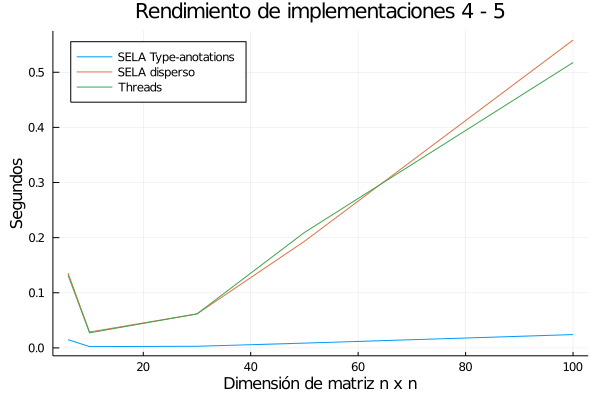

In [219]:
plot(title="Rendimiento de implementaciones 4 - 5", legend=:topleft, xaxis="Dimensión de matriz n x n", yaxis="Segundos")
plot!(mxn, [minimum(arrTEalg4[i]).time/10^9  for i=1:size(mxn)[1]], label="SELA Type-anotations")
plot!(mxn, [minimum(arrTEalg5[i]).time/10^9  for i=1:size(mxn)[1]], label="SELA disperso ")
plot!(mxn, [minimum(arrTEalg6[i]).time/10^9  for i=1:size(mxn)[1]], label="Threads")

In [220]:
TEalg4 = @benchmark mcmcalg4(ϵ, δ, A, b)

BenchmarkTools.Trial: 118 samples with 1 evaluation.
 Range (min … max):  18.227 ms … 166.939 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     32.295 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   42.329 ms ±  27.815 ms  ┊ GC (mean ± σ):  0.10% ± 0.99%

   ▃ ▇█ ▃                                                       
  ▃█▇██▆█▆▆▆█▄▆▄▃▃▆▁▆▁▃▁▅▄▁▁▁▃▁▁▁▃▁▁▁▁▁▁▁▁▁▃▁▁▃▁▁▃▁▁▁▁▅▁▁▁▁▁▁▃ ▃
  18.2 ms         Histogram: frequency by time          147 ms <

 Memory estimate: 667.48 KiB, allocs estimate: 250.

2.55816097e8 || I). Probabilidad in situ
1.08464174e8 || II). Probabilidad acumulada fuera del algoritmo, variable global
2.793492e6 || III). Variables locales
1.8227132e7 || IV). Probabilidad acumulada pre-build con envío de parámetros y type-anotations
5.20910367e8 || V). Probabilidad acumulada pre-build con envío de parámetros y type-anotations
5.19714429e8 || VI). Probabilidad acumulada pre-build con envío de parámetros y type-anotations


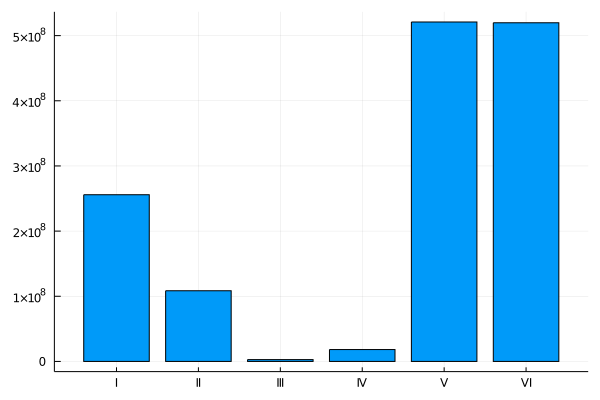

In [221]:
println(minimum(TEalg1).time," || I). Probabilidad in situ")
println(minimum(TEalg2).time," || II). Probabilidad acumulada fuera del algoritmo, variable global")
println(minimum(TEalg3).time," || III). Variables locales")
println(minimum(TEalg4).time," || IV). Probabilidad acumulada pre-build con envío de parámetros y type-anotations")
println(minimum(TEalg5).time," || V). Probabilidad acumulada pre-build con envío de parámetros y type-anotations")
println(minimum(TEalg6).time," || VI). Probabilidad acumulada pre-build con envío de parámetros y type-anotations")
using  DataFrames
arrMCMC= ["I","II","III","IV","V","VI"]
arrTime= [minimum(TEalg1).time,minimum(TEalg2).time,minimum(TEalg3).time,minimum(TEalg4).time,minimum(TEalg5).time,minimum(TEalg6).time]
bar(arrMCMC, arrTime,  label="")

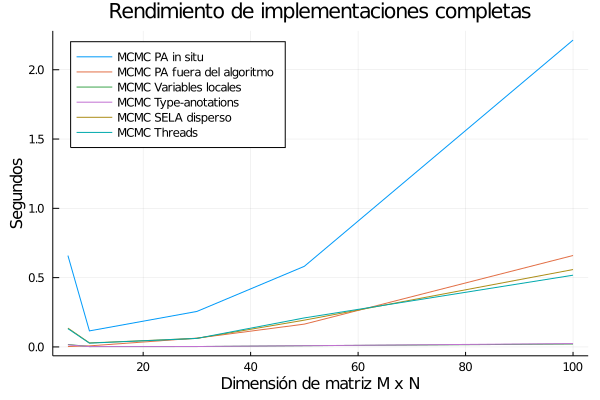

In [291]:
plot(title="Rendimiento de implementaciones completas", legend=:topleft, xaxis="Dimensión de matriz M x N", yaxis="Segundos")
plot!(mxn, [minimum(arrTEalg1[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC PA in situ")
plot!(mxn, [minimum(arrTEalg2[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC PA fuera del algoritmo")
plot!(mxn, [minimum(arrTEalg3[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC Variables locales")
plot!(mxn, [minimum(arrTEalg4[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC Type-anotations")
plot!(mxn, [minimum(arrTEalg5[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC SELA disperso ")
plot!(mxn, [minimum(arrTEalg6[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC Threads")

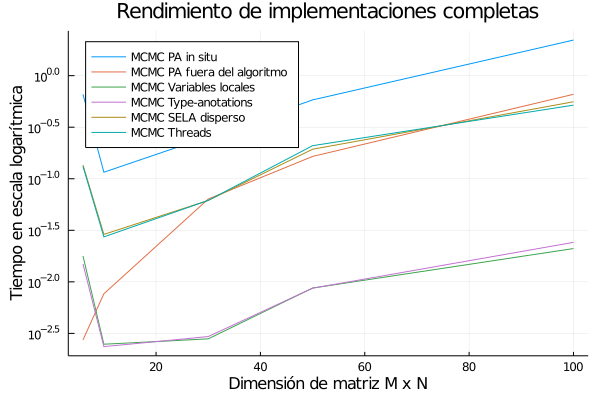

In [290]:
plot(title="Rendimiento de implementaciones completas", legend=:topleft, xaxis="Dimensión de matriz M x N", yaxis = ("Tiempo en escala logarítmica", :log))
plot!(mxn, [minimum(arrTEalg1[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC PA in situ")
plot!(mxn, [minimum(arrTEalg2[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC PA fuera del algoritmo")
plot!(mxn, [minimum(arrTEalg3[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC Variables locales")
plot!(mxn, [minimum(arrTEalg4[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC Type-anotations")
plot!(mxn, [minimum(arrTEalg5[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC SELA disperso ")
plot!(mxn, [minimum(arrTEalg6[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC Threads")